## <center><font color=green> Activity1: Workflow of Training a Medical AI Model with Pytorch</font></center>

Authors: [Zhehua Mao](z.mao@ucl.ac.uk), [Miguel Xochicale](m.xochicale@ucl.ac.uk)

# Introduction

In this hands-on activity, you will go through general steps of training a neural networks in practice. Here we use a segmentation model as an example for identifing polyps during colonoscopies. We will see how this model is trained on the Kvasir-SEG dataset [1], using the ColonSegNet model architecture [2].

[1] Jha, Debesh, Pia H. Smedsrud, Michael A. Riegler, Pål Halvorsen, Thomas de Lange, Dag Johansen, and Håvard D. Johansen, "Kvasir-seg: A segmented polyp dataset" Proceedings of the International Conference on Multimedia Modeling, pp. 451-462, 2020.

[2] Jha D, Ali S, Tomar NK, Johansen HD, Johansen D, Rittscher J, Riegler MA, Halvorsen P. Real-Time Polyp Detection, Localization and Segmentation in Colonoscopy Using Deep Learning. IEEE Access. 2021 Mar 4;9:40496-40510. doi: 10.1109/ACCESS.2021.3063716. PMID: 33747684; PMCID: PMC7968127.

To use the notebook, you will need to first log in to your google account. <br/> In addtion, do not forget to change the runtime type to GPU by clicking `Runtime` -> `Change runtime type` -> Selecting `"Python 3"` and `"GPU"` -> clicking `Save`. <br/>
After that you can click `Runtime` -> `Run all` **OR** run the codes step by step by clicking `Run cell` button in the notebook.

# Preparing codes

In [ ]:
# change to workspace directory
import os
os.chdir('/content/')

In [ ]:
# clone the codes for ColonSegNEt
if not os.path.exists('ColonSegNet'):
  print('Cloning repository...')
  !git clone https://github.com/ZH-Mao/ColonSegNet.git

In [ ]:
# Change to the folder of ColonSegNet
os.chdir('/content/ColonSegNet')
os.getcwd()

'/content/ColonSegNet'

# Import dependencies

In [ ]:
import time
import random
import numpy as np
from glob import glob
import cv2
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm

from data import load_data, KvasirDataset
from utils import (
    seeding,shuffling, make_channel_first, make_channel_last, create_dir, epoch_time, print_and_save
)
from model import CompNet
from loss import DiceLoss, DiceBCELoss, IoUBCELoss

# set a random seed for reproduction of the results
seeding(42)

# Download dataset

In [ ]:
if not os.path.exists('Kvasir-SEG'):
    print('Downloading data...')
    !wget https://datasets.simula.no/downloads/kvasir-seg.zip
    !unzip -q kvasir-seg.zip && rm kvasir-seg.zip
    !mv train.txt val.txt ./Kvasir-SEG

In [ ]:
# Define a function for data visualization
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name)
        plt.imshow(image)
    plt.show()

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


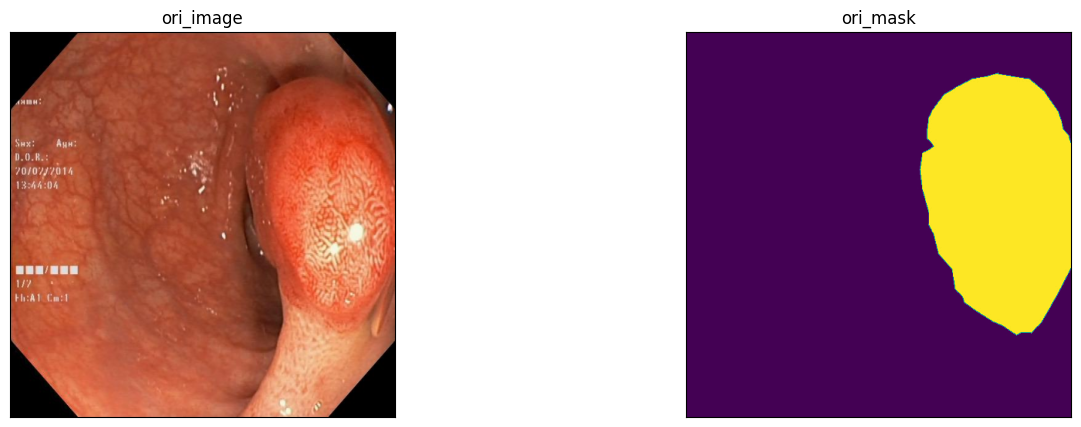

In [ ]:
# Have a look at original data
input_size = (512, 512)
path = "/content/ColonSegNet/Kvasir-SEG"
(train_x, train_y), (valid_x, valid_y) = load_data(path)
ori_dataset = KvasirDataset(train_x, train_y, input_size)

image, mask, _ = ori_dataset[5] # get one sample

print(image.shape)
print(mask.shape)

visualize(
    ori_image = cv2.cvtColor(np.transpose(image.numpy(), (1,2,0)), cv2.COLOR_BGR2RGB),
    ori_mask=mask.squeeze(),
)

# Data augmentation

[![Albumentation logo](https://albumentations.readthedocs.io/en/latest/_static/logo.png)](https://github.com/albu/albumentations)

The [albumentation](https://github.com/albu/albumentations) library works with images and masks at the same time, which is what we need.

In [ ]:
# import data orgmentation function which is implemented with albumentation library
# in this example, data augmentation is realized offline, augmented data are save in the folder 'new_data'
from data_aug import augment_data

path = "/content/ColonSegNet/Kvasir-SEG"
(train_x, train_y), (test_x, test_y) = load_data(path)

print("Original_Train: ", len(train_x))
print("Original_Valid: ", len(test_x))

create_dir("new_data/train/image/")
create_dir("new_data/train/mask/")
create_dir("new_data/test/image/")
create_dir("new_data/test/mask/")

augment_data(train_x, train_y, "new_data/train/", augment=False)
augment_data(test_x, test_y, "new_data/test/", augment=False)

Original_Train:  880
Original_Valid:  120


100%|██████████| 120/120 [00:02<00:00, 54.74it/s]


# Data loaders

In [ ]:
# Define datasets
""" Directories """
create_dir("files")

""" Training logfile """
train_log_path = "files/train_log.txt"
if os.path.exists(train_log_path):
    print("Log file exists")
else:
    train_log = open("files/train_log.txt", "w")
    train_log.write("\n")
    train_log.close()

""" Load dataset """
train_x = sorted(glob("new_data/train/image/*"))
train_y = sorted(glob("new_data/train/mask/*"))

valid_x = sorted(glob("new_data/test/image/*"))
valid_y = sorted(glob("new_data/test/mask/*"))

# path = "/../../Kvasir-SEG/"
# (train_x, train_y), (valid_x, valid_y) = load_data(path)

train_x, train_y = shuffling(train_x, train_y)
data_str = f"Dataset Size after Augmentation:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print_and_save(train_log_path, data_str)

""" Dataset """
train_dataset = KvasirDataset(train_x, train_y, input_size)
valid_dataset = KvasirDataset(valid_x, valid_y, input_size)


Log file exists
Dataset Size after Augmentation:
Train: 880 - Valid: 120



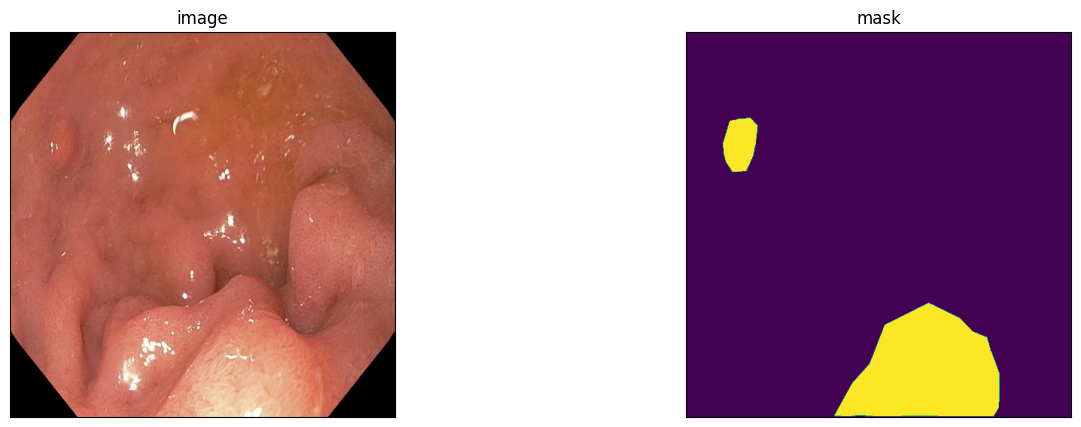

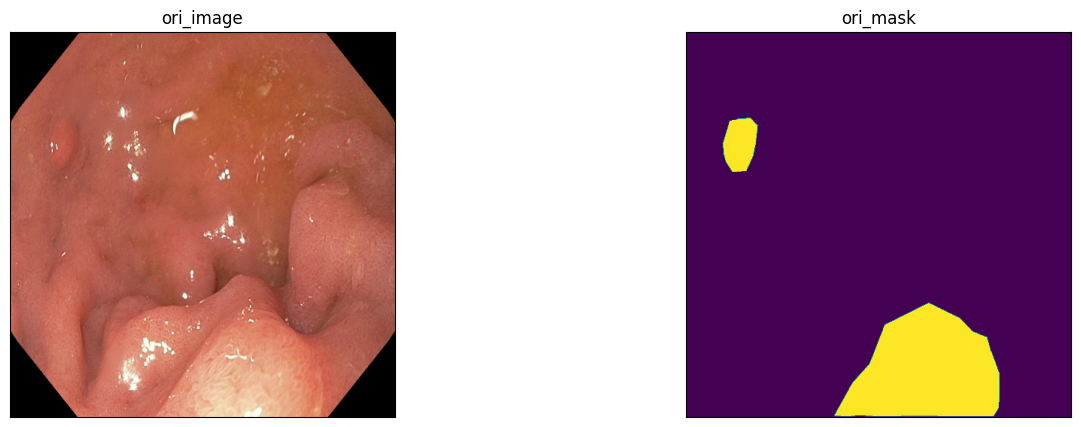

In [ ]:
# Have a look at an augmented image and original image
image, mask, name = train_dataset[4] # get one sample
visualize(
    image = cv2.cvtColor(np.transpose(image.numpy(), (1,2,0)), cv2.COLOR_BGR2RGB),
    mask=mask.squeeze(),
)
# ori_image = cv2.imread(os.path.join('/content/ColonSegNet/Kvasir-SEG/images', name.split('_')[0]+'.jpg'), cv2.IMREAD_COLOR)
# ori_mask = cv2.imread(os.path.join('/content/ColonSegNet/Kvasir-SEG/masks',  name.split('_')[0]+'.jpg'), cv2.IMREAD_GRAYSCALE)
ori_image = cv2.imread(os.path.join('/content/ColonSegNet/Kvasir-SEG/images', name.split('.')[0]+'.jpg'), cv2.IMREAD_COLOR)
ori_mask = cv2.imread(os.path.join('/content/ColonSegNet/Kvasir-SEG/masks',  name.split('.')[0]+'.jpg'), cv2.IMREAD_GRAYSCALE)
ori_image = cv2.resize(ori_image, input_size)/255.0
ori_mask = cv2.resize(ori_mask, input_size)/255.0
visualize(
    ori_image = cv2.cvtColor(ori_image.astype(np.float32), cv2.COLOR_BGR2RGB),
    ori_mask = ori_mask.astype(np.float32),
)


In [ ]:
# Define data loader
batch_size = 6
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# Define functions for one training and validation epoch

In [ ]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0

    model.train()
    for i, (x, y, _) in enumerate(tqdm(loader)):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        yp = model(x)
        loss = loss_fn(yp, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss


In [ ]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0

    model.eval()
    with torch.no_grad():
        for i, (x, y, _) in enumerate(tqdm(loader)):
            x = x.to(device)
            y = y.to(device)

            yp = model(x)
            loss = loss_fn(yp, y)
            epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

# Define model and put it to GPU

ColonSegNet is an encoder-decoder that uses residual block with squeeze and excitation network as the main component. The use of fewer trainable parameters makes ColonSegNet a very light-weight network that leads to real-time performance.
<!-- ![](https://drive.google.com/uc?export=view&id=1749SISQLE2wMWIe2Sud_LWg0V1WICvBu) -->

<div>
<img src="https://drive.google.com/uc?export=view&id=1749SISQLE2wMWIe2Sud_LWg0V1WICvBu" width="400"/>
</div>


In [ ]:
""" Model """
device = torch.device('cuda')
model = CompNet()
# model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)

# print the architecture of the model
print(model)

CompNet(
  (e1): EncoderBlock(
    (residual_block1): ResidualBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
        )
        (sigmoid): Sigmoid()
      )
      (relu): ReLU(inplace=True)
    )
    (strided_conv): StridedConvBlock(
      (conv): Conv2d(64, 64, kernel_s

# Define optimizer for network optimization

In [ ]:
num_epochs = 1
lr = 1e-4
checkpoint_path = "files/checkpoint.pth"
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()
# loss_fn = IoUBCELoss()
loss_name = "BCE Dice Loss"

data_str = f"Hyperparameters:\nImage Size: {input_size}\nBatch Size: {batch_size}\nLR: {lr}\nEpochs: {num_epochs}\n"
data_str += f"Optimizer: Adam\nLoss: {loss_name}\n"
print_and_save(train_log_path, data_str)

Hyperparameters:
Image Size: (512, 512)
Batch Size: 6
LR: 0.0001
Epochs: 1
Optimizer: Adam
Loss: BCE Dice Loss



# Train the model

In [ ]:
""" Training the model. """
best_valid_loss = float('inf')
for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)
    scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print_and_save(train_log_path, data_str)

 84%|████████▍ | 124/147 [03:59<00:45,  1.98s/it]

# Question
<div>
<img src="https://drive.google.com/uc?export=view&id=17F9TTjlpGa5H4BeFzDGd8e0VzWrydtTq" width="400"/>
</div>

In this example, we are using an offline augmentation method. Generally, online augmentation is preferred. Do you know how to implement it? Give it a try!